# Studying mobility changes due to covid 19 political measures

#### Using Google mobility dataset from https://www.google.com/covid19/mobility/

In [1]:
import math
import numpy as np
import pandas as pd
from random import randint

import matplotlib.pyplot as plt

from scipy.optimize import minimize

import requests as re
import json as js

import time
from datetime import datetime
from dateutil.parser import *
import itertools

## import data for mobility from Google

In [2]:
dfm = pd.read_csv("https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv?cachebust=a88b56a24e1a1e25", low_memory = False)
dfm.head()

,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


#### suppress and rename columns

In [3]:
dfm['date'] = pd.to_datetime(dfm['date'])
dfm = dfm[dfm.isna()['sub_region_1']]
dfm = dfm.drop(columns = ['sub_region_1','sub_region_2','country_region_code'])
dfm = dfm.rename(columns = {'country_region' : 'Country',
                            'grocery_and_pharmacy_percent_change_from_baseline' : 'Grocery & pharmacy',
                            'parks_percent_change_from_baseline' : 'Parks',
                            'residential_percent_change_from_baseline' : 'Residential',
                            'retail_and_recreation_percent_change_from_baseline': 'Retail & recreation',
                            'transit_stations_percent_change_from_baseline' : 'Transit stations',
                            'workplaces_percent_change_from_baseline' : 'Workplace'})
dfm.head()

,Country,date,Retail & recreation,Grocery & pharmacy,Parks,Transit stations,Workplace,Residential
0,United Arab Emirates,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,United Arab Emirates,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,United Arab Emirates,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,United Arab Emirates,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,United Arab Emirates,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


#### use date as index and countries as multiindexed columns

In [4]:
df = dfm.pivot_table(index = 'date',columns = ['Country'])
df = df.swaplevel(i=0,j=1,axis=1).sort_index(axis=1)
df = df.rename_axis(('Country','Sector'), axis=1)
df.head()

Country           Afghanistan                                        \
Sector     Grocery & pharmacy Parks Residential Retail & recreation   
date                                                                  
2020-02-15              -10.0   0.0         5.0                -9.0   
2020-02-16               11.0   1.0         0.0                 3.0   
2020-02-17               11.0   2.0        -1.0                 6.0   
2020-02-18                5.0   3.0        -1.0                 3.0   
2020-02-19                3.0   1.0         1.0                -1.0   

Country                                           Angola                    \
Sector     Transit stations Workplace Grocery & pharmacy Parks Residential   
date                                                                         
2020-02-15             -2.0     -28.0               -2.0   7.0         1.0   
2020-02-16             10.0       4.0                0.0 -11.0         2.0   
2020-02-17              9.0       5.0               -4.0   2.0         0.0   
2020-02-18              9.0       6.0               -4.0  -4.0        -1.0   
2020-02-19              0.0       5.0              -12.0  -3.0         1.0   

Country                         ...      Zambia                      \
Sector     Retail & recreation  ... Residential Retail & recreation   
date                            ...                                   
2020-02-15                 3.0  ...         4.0                -1.0   
2020-02-16                -4.0  ...         3.0                -4.0   
2020-02-17                -6.0  ...         3.0                -8.0   
2020-02-18                -3.0  ...         2.0                -6.0   
2020-02-19               -10.0  ...         3.0                -8.0   

Country                                         Zimbabwe                    \
Sector     Transit stations Workplace Grocery & pharmacy Parks Residential   
date                                                                         
2020-02-15             -5.0       7.0                0.0  -1.0         1.0   
2020-02-16             -7.0       2.0               -3.0  -6.0         3.0   
2020-02-17             -8.0       8.0               -2.0  -1.0         1.0   
2020-02-18             -4.0       6.0                4.0   0.0         2.0   
2020-02-19             -7.0       4.0                1.0  -4.0         1.0   

Country                                                    
Sector     Retail & recreation Transit stations Workplace  
date                                                       
2020-02-15                -4.0            -11.0       0.0  
2020-02-16                -8.0            -11.0      -2.0  
2020-02-17                -3.0             -7.0       8.0  
2020-02-18                 1.0             -6.0       7.0  
2020-02-19                -2.0             -8.0       5.0  

[5 rows x 787 columns]

#### check visually whether the dataset shows clear trends: per-sector averages over countries

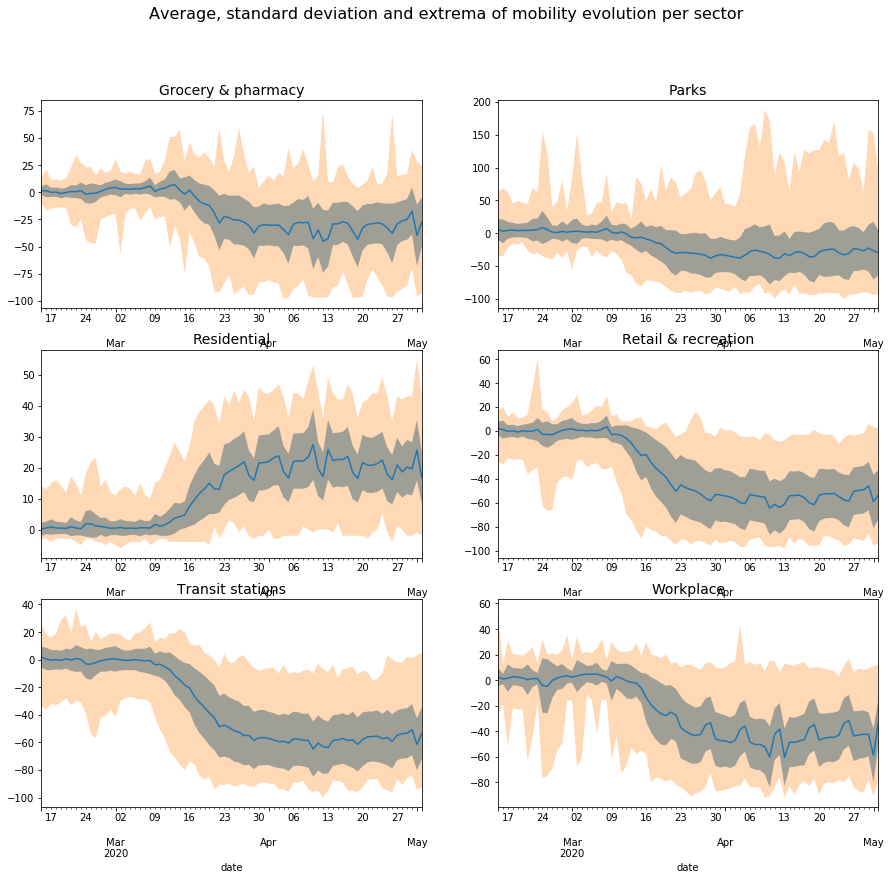

In [5]:
plt.figure(figsize = (15,13)).suptitle('Average, standard deviation and extrema of mobility evolution per sector',size=16)
count = 0
for sector, new_df in df.groupby(level=1, axis=1):
    count += 1
    ax=plt.subplot(3,2,count)
    ax.set_title(sector,size=14)
    avg = new_df.mean(axis=1)
    avg.plot(legend=None)
    dev = np.std(new_df, axis=1)
    plt.fill_between(new_df.index, avg-dev,avg+dev, alpha=0.6)
    plt.fill_between(new_df.index, new_df.min(axis=1),new_df.max(axis=1), alpha=0.3)
plt.show()

#### improve the representation by adding weekends&features

In [6]:
df.loc[:, pd.IndexSlice[:, 'Residential']] *= -1 # change sign for residential mobility change

In [7]:
# create functions to highlight weekends
    # 1. find indices of weekend in df.index
def find_weekend_indices(datetime_array):
    indices = []
    for i in range(len(datetime_array)):
        if datetime_array[i].weekday() >= 5:
            indices.append(i)
    return indices

    # 2. highlight weekends in the plot
def highlight_datetimes(indices, ax):
    i = 0
    while i < len(indices)-1:
        ax.axvspan(df.index[indices[i]], df.index[indices[i] + 1], facecolor='green', edgecolor='none', alpha=.05)
        i += 1

In [8]:
df_by_sector = df.groupby(level=1,axis=1).mean()
df_by_sector.loc[:,'All sectors'] = df_by_sector.loc[:,'Grocery & pharmacy':'Workplace'].mean(axis=1)
df_by_sector.head()

Sector,Grocery & pharmacy,Parks,Residential,Retail & recreation,Transit stations,Workplace,All sectors
date,,,,,,,
2020-02-15,1.465649,5.546154,-0.178295,2.128788,1.730769,2.442748,2.189302
2020-02-16,1.404580,2.692308,-0.503937,1.143939,0.476923,0.830769,1.007430
2020-02-17,-0.068702,4.207692,-0.844961,-0.386364,-0.328244,1.492424,0.678641
2020-02-18,0.128788,4.407692,-0.527132,0.128788,-0.068702,2.704545,1.128997
2020-02-19,-1.076336,3.800000,-0.472868,-0.939394,-0.450382,2.325758,0.531130


These graphs show which sectors underwent the largest evolution due to confinement measures.


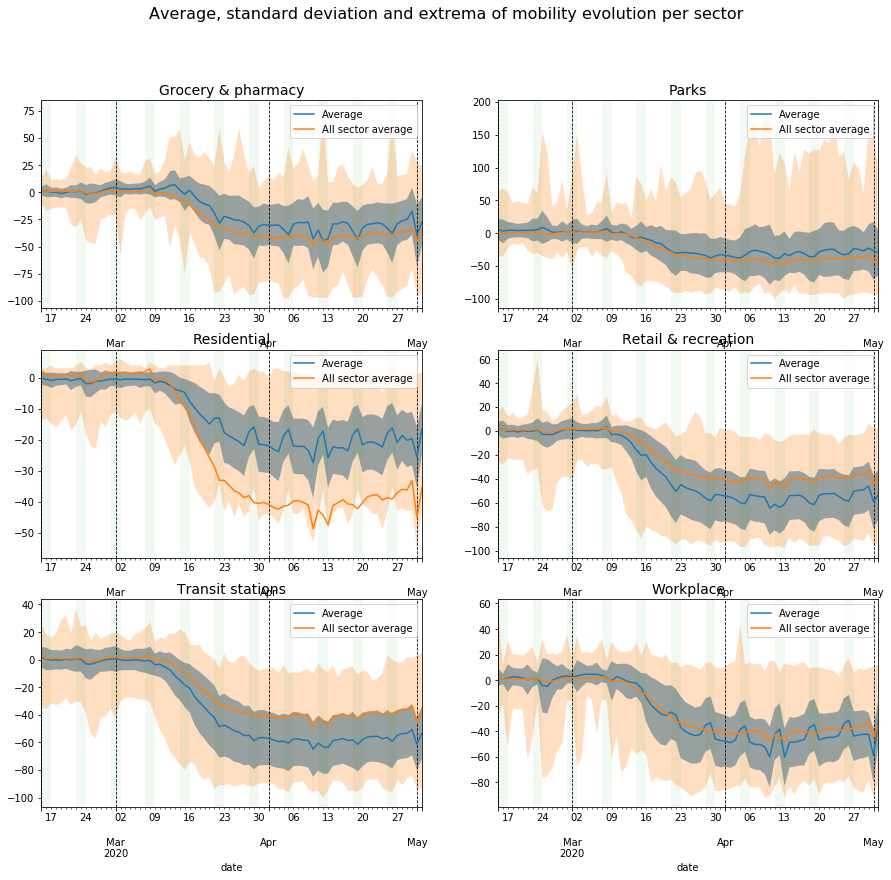

In [9]:
# show temporal evolution for each sector as compared to mean
plt.figure(figsize = (15,13)).suptitle('Average, standard deviation and extrema of mobility evolution per sector',size=16)
count = 0
for sector, new_df in df.groupby(level=1, axis=1):
    count += 1
    ax = plt.subplot(3,2,count)
    ax.set_title(sector,size=14)
    
    # plot averages
    avg = new_df.mean(axis=1)
    avg.plot()
    df_by_sector['All sectors'].plot().legend(['Average','All sector average'])
    
    # display standard deviation and min-max range
    dev = np.std(new_df, axis=1)
    plt.fill_between(new_df.index, avg-dev,avg+dev, alpha=0.6)
    plt.fill_between(new_df.index, new_df.min(axis=1),new_df.max(axis=1), alpha=0.25)
    
    # display weekends and change of month
    weekend_indices = find_weekend_indices(new_df.index)
    highlight_datetimes(weekend_indices, ax)
    ax.xaxis.grid(b=True, which='major', color='black', linestyle='--', alpha=1)

print('These graphs show which sectors underwent the largest evolution due to confinement measures.')   
plt.show()

## fit a sigmoid function

#### define sigmoid function and cost function

In [10]:
def sigmoid(x,l,m,a,b):
    sig = []

    for i in x:
        # truncation of the the argument of exp() to avoid overflowing error
        if l*(i-m) > 20:
            sig.append(a+b)
            
        elif l*(i-m) < -20:
            sig.append(b)
            
        else:
            try:
                sig.append(a / (1 + np.exp( -l*(i-m) ) )+b )
                
            except OverflowError: #custom error message for debugging
                print(l,m,a,b)
                print(sig)
                print('error = ' + str(np.mean( (y[0:len(sig)] - sig) **2 )))
                break

    return sig

In [11]:
def sumsq(p):
    l,m,a,b = p
    error = np.mean( (y - sigmoid(x,l,m,a,b)) **2 )
    #print(l,m,a,b,error)
    return error

### proof-of concept with a single fit

#### integer x-coordinate and y train 

In [12]:
x = df.index.dayofyear
x = x.astype('float')
x -= min(x)

In [13]:
df_fit = pd.DataFrame()
df_fit['y'] = df_by_sector['Transit stations']
y = df_fit['y']

#### fit & visual check

In [14]:
msol = minimize(sumsq, [0.001,0.001,0.001,0.001], method='L-BFGS-B')
msol

      fun: 4.650289148912484
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.46069873e-06, -2.22044605e-06, -3.55271368e-07, -3.55271368e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 275
      nit: 36
   status: 0
  success: True
        x: array([ 3.14957451e-01,  3.16953262e+01, -5.80615376e+01,  5.42333457e-02])

In [15]:
l,m,a,b = msol['x']
df_fit['y_fit'] = sigmoid(x,l,m,a,b)

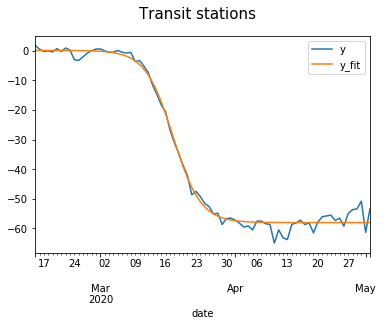

In [16]:
df_fit.plot()
plt.suptitle('Transit stations',size= 15)
plt.show()
# sig = a  *  1 / (1 + np.exp( -l*(x-m) ) )+b 

### generalisation 

#### creation of an empty dataframe to gather the fitting coefficients

In [17]:
df_param = df.reset_index()
df_param = df_param.drop(index = df_param.index)
df_param = df_param.drop(columns = 'date',level=0)
df_param['parameters'] = ['acuteness','transition day','intensity','offset','error']
df_param = df_param.set_index('parameters')
df_param

Country               Afghanistan                                        \
Sector         Grocery & pharmacy Parks Residential Retail & recreation   
parameters                                                                
acuteness                     NaN   NaN         NaN                 NaN   
transition day                NaN   NaN         NaN                 NaN   
intensity                     NaN   NaN         NaN                 NaN   
offset                        NaN   NaN         NaN                 NaN   
error                         NaN   NaN         NaN                 NaN   

Country                                               Angola        \
Sector         Transit stations Workplace Grocery & pharmacy Parks   
parameters                                                           
acuteness                   NaN       NaN                NaN   NaN   
transition day              NaN       NaN                NaN   NaN   
intensity                   NaN       NaN                NaN   NaN   
offset                      NaN       NaN                NaN   NaN   
error                       NaN       NaN                NaN   NaN   

Country                                         ...      Zambia  \
Sector         Residential Retail & recreation  ... Residential   
parameters                                      ...               
acuteness              NaN                 NaN  ...         NaN   
transition day         NaN                 NaN  ...         NaN   
intensity              NaN                 NaN  ...         NaN   
offset                 NaN                 NaN  ...         NaN   
error                  NaN                 NaN  ...         NaN   

Country                                                        \
Sector         Retail & recreation Transit stations Workplace   
parameters                                                      
acuteness                      NaN              NaN       NaN   
transition day                 NaN              NaN       NaN   
intensity                      NaN              NaN       NaN   
offset                         NaN              NaN       NaN   
error                          NaN              NaN       NaN   

Country                  Zimbabwe                                        \
Sector         Grocery & pharmacy Parks Residential Retail & recreation   
parameters                                                                
acuteness                     NaN   NaN         NaN                 NaN   
transition day                NaN   NaN         NaN                 NaN   
intensity                     NaN   NaN         NaN                 NaN   
offset                        NaN   NaN         NaN                 NaN   
error                         NaN   NaN         NaN                 NaN   

Country                                    
Sector         Transit stations Workplace  
parameters                                 
acuteness                   NaN       NaN  
transition day              NaN       NaN  
intensity                   NaN       NaN  
offset                      NaN       NaN  
error                       NaN       NaN  

[5 rows x 787 columns]

In [18]:
sectors = list(df_param.groupby('Sector',axis=1).min().columns.get_level_values('Sector'))
countries = list(df_param.groupby('Country',axis=1).min().columns.get_level_values('Country'))
sectors

['Grocery & pharmacy',
 'Parks',
 'Residential',
 'Retail & recreation',
 'Transit stations',
 'Workplace']

In [19]:
sector = []
region = []

for i in df_param:
    
    if region != i[0]:
        region = i[0]
        print(region)
        
    y = df.loc[:,i]  
    up = max(abs(y)) # largest plausible interval
    msol = minimize(sumsq,
                    [0.001,0.001,0.001,0.001],
                    method='L-BFGS-B',
                    bounds=[(0.2,10),(min(x),max(x)),(-up,up),(-up,up)])

    df_param.loc['acuteness',i],df_param.loc['transition day',i],df_param.loc['intensity',i],df_param.loc['offset',i] = msol['x']
    df_param.loc['error',i] = msol['fun']

Afghanistan
Angola
Antigua and Barbuda
Argentina
Aruba
Australia
Austria
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Benin
Bolivia
Bosnia and Herzegovina
Botswana
Brazil
Bulgaria
Burkina Faso
Cambodia
Cameroon
Canada
Cape Verde
Chile
Colombia
Costa Rica
Croatia
Czechia
Côte d'Ivoire
Denmark
Dominican Republic
Ecuador
Egypt
El Salvador
Estonia
Fiji
Finland
France
Gabon
Georgia
Germany
Ghana
Greece
Guatemala
Guinea-Bissau
Haiti
Honduras
Hong Kong
Hungary
India
Indonesia
Iraq
Ireland
Israel
Italy
Jamaica
Japan
Jordan
Kazakhstan
Kenya
Kuwait
Kyrgyzstan
Laos
Latvia
Lebanon
Libya
Liechtenstein
Lithuania
Luxembourg
Malaysia
Mali
Malta
Mauritius
Mexico
Moldova
Mongolia
Mozambique
Myanmar (Burma)
Namibia
Nepal
Netherlands
New Zealand
Nicaragua
Niger
Nigeria
North Macedonia
Norway
Oman
Pakistan
Panama
Papua New Guinea
Paraguay
Peru
Philippines
Poland
Portugal
Puerto Rico
Qatar
Romania
Rwanda
Réunion
Saudi Arabia
Senegal
Serbia
Singapore
Slovakia
Slovenia
South Africa
South Korea
Spain
Sri

In [20]:
df_param

Country               Afghanistan                                             \
Sector         Grocery & pharmacy      Parks Residential Retail & recreation   
parameters                                                                     
acuteness               10.000000   0.200000    0.255855            0.327306   
transition day          41.841055  43.957893   41.553795           39.285755   
intensity              -29.009708 -19.831746  -13.397798          -45.871888   
offset                   4.095380   2.785968   -0.633280            0.768710   
error                   29.594507  10.811257    3.599863           16.503771   

Country                                                Angola             \
Sector         Transit stations  Workplace Grocery & pharmacy      Parks   
parameters                                                                 
acuteness              0.202784   0.281778          10.000000   0.399198   
transition day        38.975512  38.996518          40.914660  36.175960   
intensity            -53.000000 -38.812756         -33.790774 -41.139427   
offset                 4.664319   4.018295           1.707269   4.795492   
error                 18.469525  89.343511          76.889647  58.487545   

Country                                         ...      Zambia  \
Sector         Residential Retail & recreation  ... Residential   
parameters                                      ...               
acuteness         0.497184            0.414790  ...    0.240408   
transition day   36.992501           37.254960  ...   41.983585   
intensity       -25.070895          -52.140526  ...  -11.240709   
offset           -0.197958            0.287245  ...   -2.355934   
error            19.321828           69.551820  ...    5.444342   

Country                                                          \
Sector         Retail & recreation Transit stations   Workplace   
parameters                                                        
acuteness                 0.219447         0.214811    0.309491   
transition day           40.196482        40.613455   41.389118   
intensity               -20.593565       -20.821517  -20.223525   
offset                    0.195207        -3.589038    4.260137   
error                    35.118097        21.195369  129.168072   

Country                  Zimbabwe                                             \
Sector         Grocery & pharmacy      Parks Residential Retail & recreation   
parameters                                                                     
acuteness               10.000000   0.519095    0.548989           10.000000   
transition day          43.502086  41.525026   40.945661           43.397606   
intensity              -54.979324 -42.009559  -37.389231          -59.173991   
offset                   5.093354  -3.932148   -1.362326           -2.681249   
error                   46.495858  39.997123   25.147167           47.383275   

Country                                      
Sector         Transit stations   Workplace  
parameters                                   
acuteness             10.000000   10.000000  
transition day        43.530635   43.491260  
intensity            -62.243953  -60.844958  
offset               -13.858459    2.574325  
error                 42.635482  173.925053  

[5 rows x 787 columns]

#### check visually whether the fit has worked!

0.22967415731227955 34.566860923837325 -24.27532756931376 -1.0873402100893073


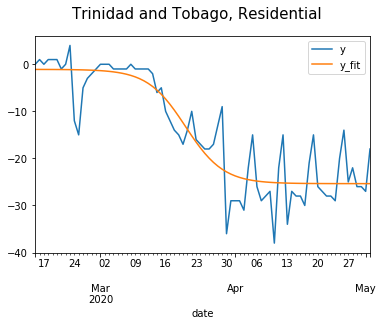

In [21]:
from random import randint
i =  randint(0,len(df_param.columns))
column = df_param.columns[i]
l,m,a,b = df_param.loc[['acuteness','transition day','intensity','offset'],column]
df_fit['y'] = df[column]
df_fit['y_fit'] = sigmoid(x,l,m,a,b)

print(l,m,a,b)
df_fit.plot()
plt.suptitle(column[0]+ ', ' + column[1],size= 15)
plt.show()

In [22]:
df['Réunion']
l,m,a,b = df_param.loc[['acuteness','transition day','intensity','offset'],column]

## Dealing with NaN values in the original dataset

###### *another idea to which I'll come back sometime*
Here I would like to interpolate for the missing values (see below an example). This assumes:
- for simple holes : dividing the data for concerned country-sector into 3 parts : before transition, after transition, during transition; perform spectral analysis to find the weekly pattern
- for periodic holes (e.g. missing data each weekends) : finding a group of countries sharing similar characteristics (same continent? similar sigmoid parameters - except offset? ...) and extrapolate to the country of interest

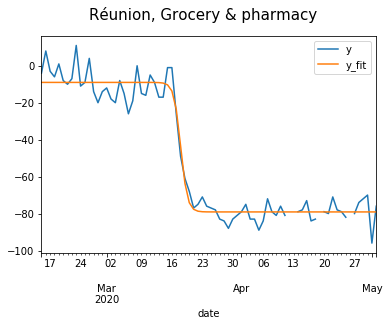

In [23]:
column = tuple(['Réunion','Grocery & pharmacy'])
l,m,a,b = df_param.loc[['acuteness','transition day','intensity','offset'],column]
df_fit['y'] = df[column]
df_fit['y_fit'] = sigmoid(x,l,m,a,b)

df_fit.plot()
plt.suptitle(column[0]+ ', ' + column[1],size= 15)
plt.show()